## Data Preparation

In [1]:
# importing Qiskit
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import CU3Gate, U1Gate, U3Gate, CSwapGate, MCXGate
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import math
import matplotlib.pyplot as plt
import numpy as np

global_qc = 0

In [2]:
# let '6' = 1, '9' = -1

X_train = [[0.987, 0.159], [0.354, 0.935]]
y_train = [1, 0]
#y_train = [1, -1]

X_test = [[0.997, -0.072], [0.338, 0.941], [0.147, 0.989], [0.999, 0.025],
          [0.999, -0.030], [0.439, 0.899], [0.987, -0.161], [0.173, 0.985]]
y_test = [1, 0, 0, 1, 1, 0, 1, 0]
#y_test = [1, -1, -1, 1, 1, -1, 1, -1]

## Classic Algorithms

In [3]:
def cal_theta(a, b):
    return 2 * np.arctan(b/a)

## Quantum Algorithms

In [4]:
def iqft(n, est_digit_start, est_digit_num):
    qc = QuantumCircuit(n)
    
    for j in range(est_digit_start + est_digit_num-1, est_digit_start -1, -1):
        for m in range(est_digit_start + est_digit_num-1, j, -1):
            qc.cp(-math.pi / float(2 ** (m - j)), m, j) # phase, control, target
        qc.h(j)
    
    
    for qubit in range(est_digit_num//2):
        qc.swap(qubit, est_digit_start + (est_digit_num-qubit-1))
    
    return qc

In [5]:
def phase_amp(n, est_digit_start, est_digit_num, target):
    qc = QuantumCircuit(n)
    
    for count in range(est_digit_num):
        divisor = 2 ** count
        qc.crx(-math.pi/divisor, count + est_digit_start, target)
    return qc

In [6]:
def phase_enc(n, est_digit_start, est_digit_num, ancilla):
    qc = QuantumCircuit(n)
    
    for count in range(est_digit_num):
        divisor = 2 ** (count+2)
        qc.cry(math.pi/divisor, count + est_digit_start, ancilla)
    return qc

In [7]:
def phase_enc_recal(n, est_digit_start, est_digit_num, ancilla):
    qc = QuantumCircuit(n)
    
    qc.cry(math.pi, est_digit_start, ancilla)
    qc.cry(math.pi / 3, est_digit_start + 1, ancilla)
    
    return qc

In [8]:
# only acts for length 1 b_register
def training_oracle(n, zero_qubit, b_register_start, ancilla, auxiliary):
    global X_train, X_test
    theta_list = []
    binary_list = []
    
    # theta calculation for each property
    for i in range(len(X_train)):
        theta_list.append(cal_theta(X_train[i][0], X_train[i][1]))
        
    # fixed length index binary string preparation | e.g.) [1,2,3,4,5] -> [001, 010, 011, 100, 101]
    for idx in range(len(X_train)):
        binary_list.append("{0:b}".format(idx))
        
    binary_length = math.ceil(math.log(len(binary_list), 2))
    if len(binary_list) != binary_length:
        for i in range(len(binary_list)):
            temp = []
            s = binary_list[i]
            for j in range(binary_length - len(s)):
                temp.append('0')
            s = temp + list(s)
            binary_list[i] = s
    
    # build a quantum circuit
    qc = QuantumCircuit(n)
    # place quantum gates
    for idx in range(len(binary_list)):
        for digit_pos in range(binary_length-1, -1, -1):
            if binary_list[idx][digit_pos] == '0':
                qc.x(b_register_start + digit_pos)
                
        qc.mcx([x for x in range(b_register_start, auxiliary)], [auxiliary])
        for digit_pos in range(binary_length-1, -1, -1):
            if binary_list[idx][digit_pos] == '0':
                qc.x(b_register_start + digit_pos)
                
        qc.cry(theta_list[idx], auxiliary, zero_qubit)
        
        for digit_pos in range(binary_length-1, -1, -1):
            if binary_list[idx][digit_pos] == '0':
                qc.x(b_register_start + digit_pos)
        qc.mcx([x for x in range(b_register_start, auxiliary)], [auxiliary])
        for digit_pos in range(binary_length-1, -1, -1):
            if binary_list[idx][digit_pos] == '0':
                qc.x(b_register_start + digit_pos)
                
    return qc

In [9]:
def hadamard_test(n, zero_qubit, b_register_start, test_index, ancilla):
    global X_test 
    theta0 = cal_theta(X_test[test_index][0], X_test[test_index][1])
    
    qc = QuantumCircuit(n)
    qc.cry(-theta0, ancilla, zero_qubit)
    
    qc.ch([ancilla],[b_register_start])
    
    return qc

In [10]:
def hadamard_test2(n, zero_qubit, b_register_start, test_index, ancilla):
    global X_test 
    theta0 = cal_theta(X_test[test_index][0], X_test[test_index][1])
    
    qc = QuantumCircuit(n)
    qc.cry(-theta0, ancilla, zero_qubit)
    
    return qc

In [11]:
def phase_amp_paper1(n, est_digit_start, est_digit_num, target):
    qc = QuantumCircuit(n)
    
    qc.append(U1Gate(3.17, est_digit_start), 0)
    qc.append(U1Gate(1.59, est_digit_start + 1), 1)
    qc.append(CU3Gate(math.pi, math.pi/2, -math.pi/2), [est_digit_start, target])
    qc.append(CU3Gate(math.pi/2, math.pi/2, -math.pi/2), [est_digit_start+1, target])
    return qc.inverse().inverse()

In [12]:
def phase_amp_paper2(n, est_digit_start, est_digit_num, target):
    qc = QuantumCircuit(n)
    
    qc.append(U1Gate(-3.17, est_digit_start + 1), [1])
    qc.append(U1Gate(-1.59, est_digit_start), [0])
    qc.append(CU3Gate(-math.pi/2, math.pi/2, -math.pi/2), [est_digit_start, target])
    qc.append(CU3Gate(-math.pi, math.pi/2, -math.pi/2), [est_digit_start+1, target])
    return qc.inverse().inverse()

In [13]:
def phase_amp_recal1(n, est_digit_start, est_digit_num, target):
    qc = QuantumCircuit(n)
    
    qc.append(CU3Gate(1, math.pi/2, -math.pi/2), [est_digit_start, target])
    qc.append(CU3Gate(2, math.pi/2, -math.pi/2), [est_digit_start+1, target])
    return qc.inverse().inverse()

In [14]:
def phase_amp_recal2(n, est_digit_start, est_digit_num, target):
    qc = QuantumCircuit(n)
    
    qc.append(CU3Gate(-2, math.pi/2, math.pi/2), [est_digit_start+1, target])
    qc.append(CU3Gate(-1, math.pi/2, math.pi/2), [est_digit_start, target])
    return qc.inverse().inverse()

In [15]:
def swap_test(n, state_qubit1, state_qubit2, ancilla, auxiliary):
    qc = QuantumCircuit(n)
    
    qc.h(auxiliary)
    qc.append(MCXGate(2), [ancilla, state_qubit2, state_qubit1])
    qc.append(MCXGate(3), [ancilla, auxiliary, state_qubit1, state_qubit2])
    qc.append(MCXGate(2), [ancilla, state_qubit2, state_qubit1])
    qc.h(auxiliary)
    return qc.inverse().inverse()

## Main

In [16]:
def main_func_ver1(n, test_index, ancilla, auxiliary, shots):
    global global_qc
    qc = QuantumCircuit(n,1)

    first_amp = phase_amp(n,0,2,2).to_gate()
    first_amp.label = 'Phase Amp'
    first_iqft = iqft(n,0,2).to_gate()
    first_iqft.label = 'IQFT'
    phase_encoding = phase_enc(n, 0, 2, 3).to_gate()
    phase_encoding.label = 'Phase Enc'
    second_iqft = iqft(n,0,2).to_gate().inverse()
    second_iqft.label = 'IQFT†'
    second_amp = phase_amp(n,0,2,2).inverse().to_gate()
    second_amp.label = 'Phase Amp†'
    train_oracle = training_oracle(n, 1, 2, 3, 4).to_gate()
    train_oracle.label = 'Training Oracle'
    hada_test = hadamard_test(n, 1, 2, test_index, 3).to_gate()
    hada_test.label = 'Hadamard Test'

    qc.append(U3Gate(-math.pi/2,0,0), [2])
    qc.barrier()
    qc.h([0,1])
    qc.barrier()
    qc.append(first_amp, range(n))
    qc.append(first_iqft, range(n))
    qc.barrier()
    qc.append(phase_encoding, range(n))
    qc.barrier()
    qc.append(second_iqft, range(n))
    qc.append(second_amp, range(n))
    qc.barrier()
    qc.h([0,1])
    qc.barrier()
    qc.append(train_oracle, range(n))
    qc.append(hada_test, range(n))
    qc.barrier()
    qc.h(ancilla)
    qc.measure(ancilla, 0)
    global_qc = qc
    
    aer_sim = Aer.get_backend('aer_simulator')
    t_classify = transpile(qc, aer_sim)
    qobj = assemble(t_classify, shots=shots)
    results = aer_sim.run(qobj).result()
    answer = results.get_counts()
    return answer

In [17]:
def main_func_ver2(n, test_index, ancilla, auxiliary, shots):
    global global_qc
    qc = QuantumCircuit(n,2)

    first_amp = phase_amp_paper1(n,0,2,2).to_gate()
    first_amp.label = 'Phase Amp'
    first_iqft = iqft(n,0,2).to_gate()
    first_iqft.label = 'IQFT'
    phase_encoding = phase_enc(n, 0, 2, 3).to_gate()
    phase_encoding.label = 'Phase Enc'
    second_iqft = iqft(n,0,2).to_gate().inverse()
    second_iqft.label = 'IQFT†'
    second_amp = phase_amp_paper2(n,0,2,2).to_gate()
    second_amp.label = 'Phase Amp†'
    train_oracle = training_oracle(n, 1, 2, 3, 4).to_gate()
    train_oracle.label = 'Training Oracle'
    swap_test_gate = swap_test(n, 0, 1, 3, 4).to_gate()
    swap_test_gate.label = 'Swap Test'

    qc.append(U3Gate(-math.pi/2,0,0), [2])
    qc.barrier()
    qc.h([0,1])
    qc.barrier()
    qc.append(first_amp, range(n))
    qc.append(first_iqft, range(n))
    qc.barrier()
    qc.append(phase_encoding, range(n))
    qc.barrier()
    qc.append(second_iqft, range(n))
    qc.append(second_amp, range(n))
    qc.barrier()
    qc.h([0,1])
    qc.barrier()
    qc.x(0)
    qc.h(0)
    qc.append(train_oracle, range(n))
    qc.append(swap_test_gate, range(n))
    qc.barrier()
    qc.h(ancilla)
    qc.measure(ancilla, 0)
    qc.measure(auxiliary, 1)
    global_qc = qc
    
    aer_sim = Aer.get_backend('aer_simulator')
    t_classify = transpile(qc, aer_sim)
    qobj = assemble(t_classify, shots=shots)
    results = aer_sim.run(qobj).result()
    answer = results.get_counts()
    return answer

In [57]:
def main_func_ver3(n, test_index, ancilla, auxiliary, shots):
    global global_qc
    qc = QuantumCircuit(n,3)

    first_amp =  phase_amp_recal1(n,0,2,2).to_gate()
    first_amp.label = 'Phase Amp'
    first_iqft = iqft(n,0,2).to_gate()
    first_iqft.label = 'IQFT'
    phase_encoding = phase_enc(n, 0, 2, 3).to_gate()
    phase_encoding.label = 'Phase Enc'
    second_iqft = iqft(n,0,2).to_gate().inverse()
    second_iqft.label = 'IQFT†'
    second_amp = phase_amp_recal2(n,0,2,2).to_gate()
    second_amp.label = 'Phase Amp†'
    train_oracle = training_oracle(n, 1, 2, 3, 4).to_gate()
    train_oracle.label = 'Training Oracle'
    hada_test_gate = hadamard_test(n, 1, 2, test_index, 3).to_gate()
    hada_test_gate.label = ' Hadamard Test'

    qc.append(U3Gate(-math.pi/2,0,0), [2])
    qc.barrier()
    qc.h([0,1])
    qc.barrier()
    qc.append(first_amp, range(n))
    qc.append(first_iqft, range(n))
    qc.barrier()
    qc.append(phase_encoding, range(n))
    qc.barrier()
    qc.append(second_iqft, range(n))
    qc.append(second_amp, range(n))
    qc.barrier()
    qc.h([0,1])
    
    
    qc.barrier()
    qc.append(train_oracle, range(n))
    qc.append(hada_test_gate, range(n))
    qc.barrier()
    qc.h(ancilla)
    #qc.measure(ancilla-1, 1)
    qc.measure(ancilla, 0)
    global_qc = qc
    '''
    qc.measure(ancilla-1, 1)
    qc.measure(ancilla, 0)
    global_qc = qc
    '''
    aer_sim = Aer.get_backend('aer_simulator')
    t_classify = transpile(qc, aer_sim)
    qobj = assemble(t_classify, shots=shots)
    results = aer_sim.run(qobj).result()
    answer = results.get_counts()
    return answer

## Simulation

In [58]:
import pandas as pd

In [85]:
predicts = []
shots = 8192
test_index = 3

for test_index in range(len(y_test)):
    row = main_func_ver3(5, test_index, 3, 4, shots)
    ptg = [row['000']/shots, row['001']/shots]
    predicts.append(ptg)
pd.DataFrame(predicts)

#plot_histogram(main_func_ver3(5, test_index, 3, 4, shots))

,0,1
0,0.519653,0.480347
1,0.472412,0.527588
2,0.468872,0.531128
3,0.511230,0.488770
4,0.512573,0.487427
5,0.467529,0.532471
6,0.515381,0.484619
7,0.463257,0.536743


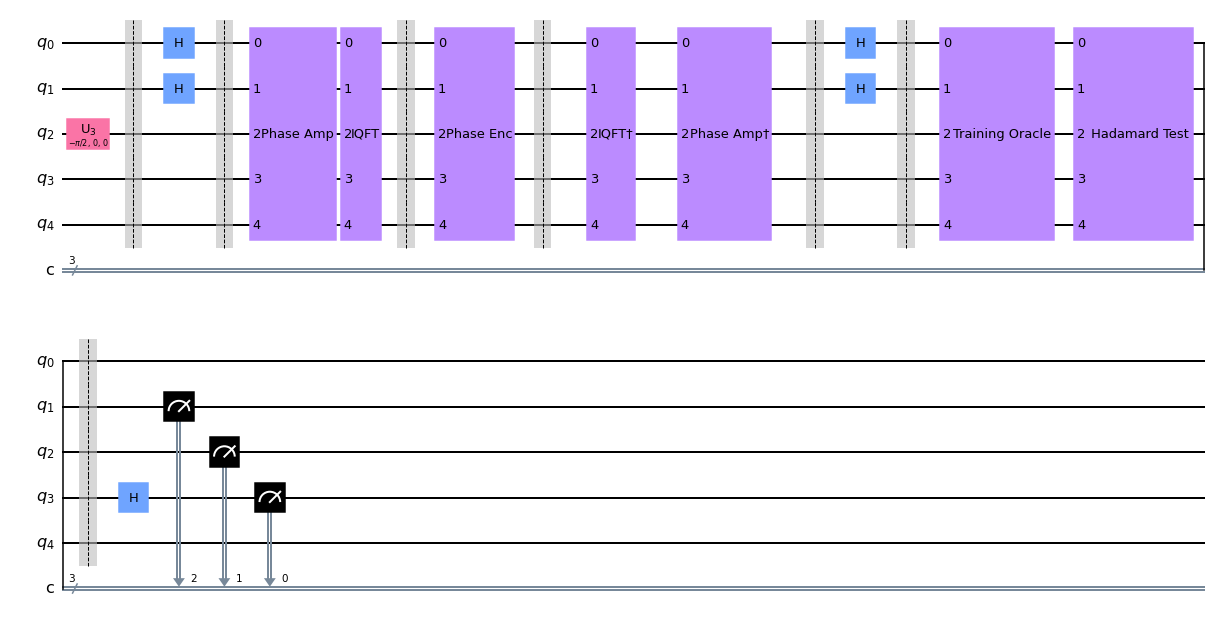

In [53]:
global_qc.draw()

## Playground

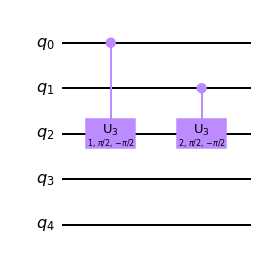

In [109]:
n = 5
test_index = 7
'''
    first_amp =  phase_amp(n,0,2,2).to_gate()
    first_amp.label = 'Phase Amp'
    first_iqft = iqft(n,0,2).to_gate()
    first_iqft.label = 'IQFT'
    phase_encoding = phase_enc(n, 0, 2, 3).to_gate()
    phase_encoding.label = 'Phase Enc'
    second_iqft = iqft(n,0,2).to_gate().inverse()
    second_iqft.label = 'IQFT†'
    second_amp =phase_amp(n,0,2,2).inverse().to_gate()
    second_amp.label = 'Phase Amp†'
    train_oracle = training_oracle(n, 1, 2, 3, 4).to_gate()
    train_oracle.label = 'Training Oracle'
    hada_test_gate = hadamard_test(n, 1, 2, test_index, 3).to_gate()
    hada_test_gate.label = ' Hadamard Test'
'''
amp = phase_amp_recal1(n,0,2,2)
amp.draw()


In [ ]:
list(range(1,-1,-1))

In [ ]:
def phase_amp_paper(n=5, est_digit_start=0, est_digit_num=2, target=2):
    qc = QuantumCircuit(n)
    
    qc.append(U1Gate(3.17, est_digit_start), [0])
    qc.append(U1Gate(1.59, est_digit_start + 1), [1])
    qc.append(CU3Gate(math.pi, math.pi/2, -math.pi/2), [est_digit_start, target])
    qc.append(CU3Gate(math.pi/2, math.pi/2, -math.pi/2), [est_digit_start+1, target])
    return qc
qc = phase_amp_paper(5,0,2,2).inverse().inverse()
qc.draw()

In [ ]:
    qc = QuantumCircuit(n)
    
    qc.append(U1Gate(3.17, est_digit_start), [0])
    qc.append(U1Gate(1.50, est_digit_start + 1), [1])
    qc.append(CU3Gate(math.pi, math.pi/2, -math.pi/2), [est_digit_start, target])
    qc.append(CU3Gate(math.pi/2, math.pi/2, -math.pi/2), [est_digit_start+1, target])

In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
t_classify = transpile(global_qc, aer_sim)
qobj = assemble(t_classify, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()